# Import and definitions

In [1]:
import sys
import zmq
import uuid
import glob
import yaml
from numpy import pi
import numpy as np
import qutip as qt

# Communication setup
Replace '127.0.0.1' with the IP of the LabView machine. Hostnames might confuse the queue interface.

In [2]:
calibration_daemon_experiment_URI = "tcp://127.0.0.1:5559"
calibration_daemon_searcher_URI = "tcp://127.0.0.1:5560"

rcvtimeout = 30000
search_id = str(uuid.uuid4())
print(f"I am the calibration searcher.\nMy ID for this run is {search_id}\n")

# Start communication
print(f"Connecting to client {calibration_daemon_experiment_URI} ... ", flush=True, end='')
context = zmq.Context()
socketrep = context.socket(zmq.REP)
try:
    socketrep.bind(calibration_daemon_searcher_URI)
except zmq.ZMQError:
    print("Socket already in use. Rebinding ...")
    socketrep.unbind(calibration_daemon_searcher_URI)
    socketrep.bind(calibration_daemon_searcher_URI)
    print("Done.")

socketreq = context.socket(zmq.REQ)
socketreq.setsockopt(zmq.LINGER, 0)  #NEW Added by Edwar to flush the queue
socketreq.connect(calibration_daemon_experiment_URI)

socketrep.RCVTIMEO = rcvtimeout  # added timeout to kill rcv if nothing comes
socketreq.RCVTIMEO = rcvtimeout
print(f"done\n\n", flush=True)

I am the calibration searcher.
My ID for this run is 5f5dc9ef-e7b7-44b2-893e-fd059582adde

Connecting to client tcp://127.0.0.1:5559 ... done




# Specify initial pulse and bounds

In [3]:
handmade_pulse = {
        'control1': {
            'carrier1': {
                'freq': 6e9*2*pi,
                'pulses': {
                    'pulse1': {
                        'amp': 15e6*2*pi,
                        't_up': 5e-9,
                        't_down': 45e-9,
                        'xy_angle': 0
                        }
                    }
                }
            }
        }
pulse_bounds = {
        'control1': {
            'carrier1': {
                'freq': [1e9*2*pi, 15e9*2*pi],
                'pulses': {
                    'pulse1': {
                        'amp':  [1e3*2*pi, 10e9*2*pi],
                        't_up': [2e-9, 98e-9],
                        't_down': [2e-9, 98e-9],
                        'xy_angle': [-pi, pi]
                        }
                    }
                }
            }
        }

# Evaluation function

Provide a function, specific to your experimental setup, that takes a several sets of parameters and provides a figure of merit for each.

In [20]:
def evaluate_pulse(gate, samples):
    global search_id
    infidelities = []
    for q in samples:
        pulse_id = str(uuid.uuid4())
        gate.print_pulse(q)
        gate.plot_control_fields(q)
        pulse = gate.get_IQ(q)
        ts = np.linspace(0, 50e-9, 51)
        Is = pulse['I'](ts)
        Qs = pulse['Q'](ts)
        non0_mask = np.nonzero(Is * Qs) 
        pulse['I'] = Is[non0_mask]  
        pulse['Q'] = Qs[non0_mask]  
        request = {
                'search_id': search_id,
                'pulse_id': pulse_id,
                'pulse': pulse,
                'fidelity': 0,
                'do_stop': False
                }
        
        socketreq.send_json(request)
        receive_message = socketreq.recv_string()

        # Make sure it's the right one
        if (reply['pulse_id'] != request['pulse_id']) or (reply['search_id'] != request['search_id']):  # MAKES NO SENSE
            try:
                print(f"request: {request}", file=sys.stderr)
                print(f"reply:   {reply}", file=sys.stderr)
            except:
                print("Wrong pulse_id or search_id")
                socketreq.unbind(calibration_daemon_experiment_URI)
                socketrep.close()
                sys.exit()

        # Extract the fidelity
        infidelities.append(1-reply['fidelity'])
    return infidelities

# Import C3PO

In [5]:
from c3po.main.gate import Gate as gt
from c3po.fidelity.measurement import Experiment as exp_backend

In [22]:
X_gate = gt('qubit_1', qt.sigmax())
X_gate.set_parameters('initial', handmade_pulse)
X_gate.set_bounds(pulse_bounds)

fridge = exp_backend(evaluate_pulse)

In [23]:
X_gate.print_pulse([1, 2, 3, 4, 5])

{
    "control1": {
        "carrier1": {
            "freq": 1,
            "pulses": {
                "pulse1": {
                    "amp": 2,
                    "t_down": 4,
                    "t_up": 3,
                    "xy_angle": 5
                }
            }
        }
    }
}


# Calibration

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 5 (seed=609897, Tue May 21 16:02:50 2019)
{
    "control1": {
        "carrier1": {
            "freq": 46281274305.84427,
            "pulses": {
                "pulse1": {
                    "amp": 905635554.0987979,
                    "t_down": 1.59119240368505e-08,
                    "t_up": 5.476539986288943e-09,
                    "xy_angle": 1.4009830848368274
                }
            }
        }
    }
}


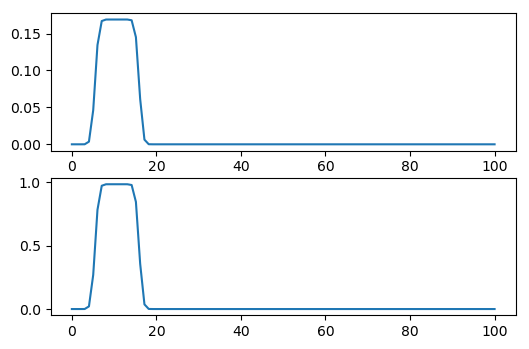

TypeError: Object of type ndarray is not JSON serializable

In [24]:
fridge.calibrate(X_gate)